# Intro

This notebook is to make sure thath the data from Anna's models is consistent with the data I use.

---
# Setup

In [1]:
# @title imports
import os

import numpy as np
import pandas as pd

from scipy.optimize import curve_fit

from tqdm import tqdm

from popy.io_tools import load_behavior
from popy.plotting.plotting_tools import *
from popy.behavior_data_tools import *
import popy.config as cfg


In [2]:
# @title helpers

'''params:
- 1-params model:
    - b = .5
    - alpha = 0.39346933933178907

- 2-params model:
    - a = 4.596906567469269
    - b = 0.690400463740454'''

def anna_1_params(x, b):
    return np.exp(-b * x)
def anna_2_params(x, a, b):
    return a * np.exp(-b * x)
def rl_1_params(x, alpha):
    return alpha * (1 - alpha) ** (len(x) - x)

def compute_qvalues(behav, mode='1_params_anna'):
    '''
    mode = '1_params_anna' or '2_params_anna' or '1_params_rl'
    '''
    

    b = 0.709
    
    if mode == '1_params_anna':
        weight_vector = np.exp(-b * np.arange(1, 9))
    elif mode == '2_params_anna':
        a = 5.088269310083372
        weight_vector = a * np.exp(-b * np.arange(1, 9))
    elif mode == '1_params_rl':
        alpha = 1 - np.exp(-b)
        weight_vector = np.array([alpha * (1 - alpha) ** (8 - i) for i in range(1, 9)[::-1]])
    elif mode == '1_params_rl_scaled':
        alpha = 1 - np.exp(-b)
        scaler = 1.5414940828992876
        weight_vector = np.array([alpha * (1 - alpha) ** (8 - i) for i in range(1, 9)[::-1]]) * scaler

    # Compute q-values
    qvalues = np.zeros((len(behav), 3))
    for i, row in behav.iterrows():
        reward_vector = np.array([row[f't-{i}'] for i in range(1, 9)])  # a vector of 1 if reward, 0 if no reward
        for j in range(3):        
            cmw_vector = np.array([1 if row[f'ch_t-{i}'] == j+1 else -1 for i in range(1, 9)])  # a vector of 1 if choice was j, -1 if not
        
            qvalues[i, j] = np.dot(weight_vector, cmw_vector * reward_vector)  # compute q-value
            
    return qvalues


---
# Section 1: Try to recreate Anna's data

In [3]:
# Load data
floc_base = cfg.PROJECT_PATH_LOCAL
floc_2param = os.path.join(floc_base, 'data', 'anna', 'KA_trip_exp_2params.csv')
floc_1param = os.path.join(floc_base, 'data', 'anna', 'KA_trip_exp_1params.csv')

## 2 param model

In [4]:
# try to recreate values
behav_anna = pd.read_csv(floc_2param)
anna_values_2_param = np.array(behav_anna[['TV_1', 'TV_2', 'TV_3']])
qvalues = compute_qvalues(behav_anna, mode='2_params_anna')

print("2-params model:")
print("MSE between anna's values and recreated values : ", round(np.mean((qvalues.flatten() - anna_values_2_param.flatten())**2), 10))
print("Correlation between recreated and anna's values: ", round(np.corrcoef(qvalues.flatten(), anna_values_2_param.flatten())[0, 1], 2))

2-params model:
MSE between anna's values and recreated values :  4.212e-07
Correlation between recreated and anna's values:  1.0


## 1 param model

In [5]:
# try to recreate values
behav_anna = pd.read_csv(floc_1param)
anna_values_1_param = np.array(behav_anna[['TV_1', 'TV_2', 'TV_3']])

qvalues = compute_qvalues(behav_anna, mode='1_params_anna')

print("1-params model:")
print("MSE between anna's valuesand recreated values : ", round(np.mean((qvalues.flatten() - anna_values_1_param.flatten())**2), 10))
print("Correlation between recreated and anna's values: ", round(np.corrcoef(qvalues.flatten(), anna_values_1_param.flatten())[0, 1], 2))

1-params model:
MSE between anna's valuesand recreated values :  0.0
Correlation between recreated and anna's values:  1.0


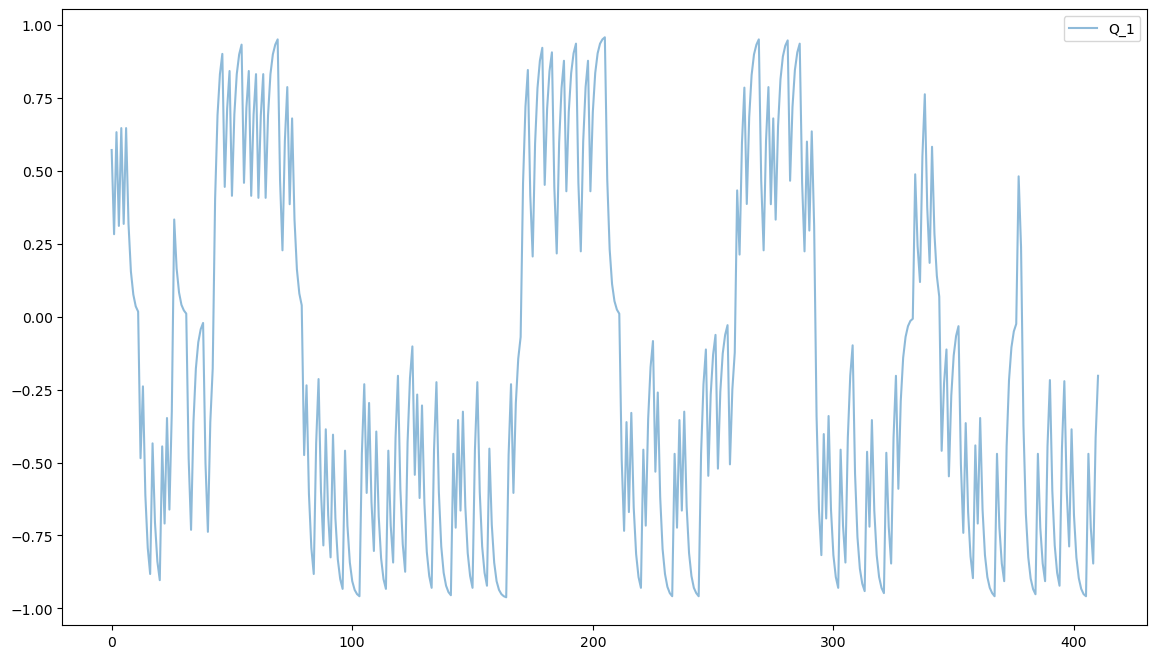

In [14]:
# plot q-values and value function
beh_sess = behav_anna.loc[behav_anna['session'] == 230520]
plt.figure(figsize=(14, 8))
plt.plot(beh_sess['TV_1'], label='Q_1', alpha=0.5)
#plt.plot(beh_sess['TV_2'], label='Q_2', alpha=0.5)
#plt.plot(beh_sess['TV_3'], label='Q_3', alpha=0.5)
#plt.plot(behav['value_function'], label='value_function')

plt.legend()


---
# Section 2: Compare Q-values to Strategy value

Here we use the 1-parameter model

In [7]:
...

Ellipsis

---
# Appendix: linking different exponential models

Consider two equivalent formulations of exponential weighting:

1) First form with decay rate $b$:
$$w_i = a \cdot e^{-b \cdot i}$$

2) Second form with parameter $\alpha$:
$$w_i = \alpha \cdot (1-\alpha)^{n-i}$$

Analytical solution of the equation:
$$a \cdot e^{-b \cdot i} = \alpha \cdot (1-\alpha)^{n-i}$$

gives the following relations between parameters:
- $\alpha = 1 - e^{-b}$
... -> THIS EQUATION IS NOT CORRECT FOR THE MOMENT!!


In [15]:
1-np.exp(-.709)

0.5078639124375139

scaler: 1.5414940825367973, a: 0.3934693402873666


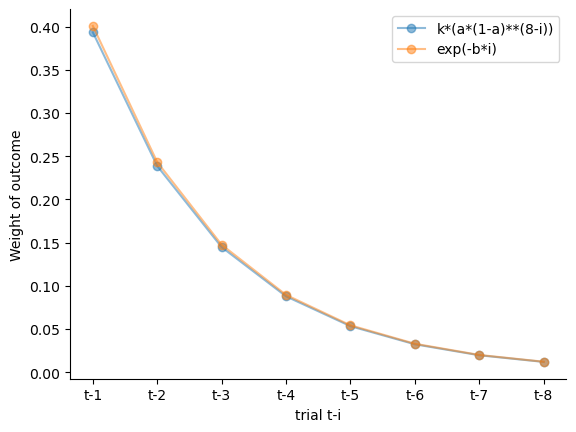

In [ ]:
import numpy as np
from scipy.optimize import fsolve
import matplotlib.pyplot as plt

b = 0.5
len_hist = 8
x = np.arange(1, len_hist+1)

# Define the function to find the root
def equations(vars):
    scaler = vars
    a = 1-np.exp(-b)
    w_a = scaler * np.array([a * (1 - a) ** (len_hist - i) for i in x[::-1]])
    w_b = np.exp(-b * np.arange(1, len_hist+1))
    return sum((w_a - w_b)**2)

# Initial guess for a and scaler
initial_guess = [1.0]

# Solve the system of equations
solution = fsolve(equations, initial_guess)
scaler = solution[0]

# Calculate w_a and w_b with the found values
a = 1-np.exp(-b)
w_a = np.array([a * (1 - a) ** (len_hist-i) for i in x[::-1]])
w_a /= w_a.sum()
w_b = np.exp(-b * np.arange(1, len_hist+1))
w_b /= w_b.sum()

print(f"scaler: {scaler}, a: {a}")

# Plot the results
plt.plot(x, w_a, label='k*(a*(1-a)**(8-i))', marker='o', alpha=0.5)
plt.plot(x, w_b, label='exp(-b*i)', marker='o', alpha=0.5)
# xticks are 't-x'
plt.xticks(x, [f't-{i}' for i in x])
plt.xlabel('trial t-i')
plt.ylabel('Weight of outcome')
# no spines
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.legend()
plt.show()